In [1]:
import os
os.chdir('D://scratch_backup//perl//alpine_reprocess//mnc-pt-pyrid//calcs//surfs//4n//No_bias')
import sys
sys.path.append('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//common_funcs//')
import numpy as np
import jdftxfuncs as jfunc
import cohpfuncs as cfunc
import plotfuncs as pfunc
import matplotlib.pyplot as plt

In [2]:
bandfile='bandProjections'
gvecfile='Gvectors'
eigfile='eigenvals'
outfile='out'
S, R, mu = jfunc.get_vars(outfile)
proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(bandfile, gvecfile, eigfile, guts=False)
T_ijk, P_uvjk, e_jk = cfunc.prepare_small_funcs(proj, E)
pCOHP_uv, pCOHP_uv_u, H_atomic_matrix = cfunc.prepare_large_funcs(e_jk,P_uvjk,nBands,nStates,wk,k_points,guts=False,docuprint=True)

pCOHP_uv(orb u index, orb v index, Egrid, Emin, Emax, dE) -> pCOHP_uv(E) array


In [3]:
orbs_dict = cfunc.orbs_idx_dict(outfile, nOrbsPerAtom)
orbsN1 = orbs_dict['N #1']
# Orbitals for carbons bonded to N #1
orbsCbN1 = orbs_dict['C #29'] + orbs_dict['C #33']
orbsPt = orbs_dict['Pt #1']

In [13]:
def plot_hmat(atom_labels, orbs_dict, hfunc):
    orbs_want = []
    div_idcs = [0]
    partition_lengths = []
    for label in atom_labels:
        orbs_want += orbs_dict[label]
        div_idcs.append(len(orbs_want))
        partition_lengths.append(len(orbs_dict[label]))
    div_idcs = div_idcs[:-1]
    matrix = np.imag(hfunc(orbs_want))
    plt.imshow(matrix)
    norbs = len(orbs_want)
    labels = [''] * norbs
    for i, idx in enumerate(div_idcs):
        plt.axvline(x=idx - 0.5, label=atom_labels[i], color='black', linestyle='--')
        plt.axhline(y=idx - 0.5, label=atom_labels[i], color='black', linestyle='--')
        labels[div_idcs[i] + int(np.floor(partition_lengths[i]/2.))] = atom_labels[i]
    plt.xticks(np.arange(-0.5, norbs - 0.5), labels, rotation=-45)
    plt.yticks(np.arange(-0.5, norbs - 0.5), labels)
    plt.colorbar()

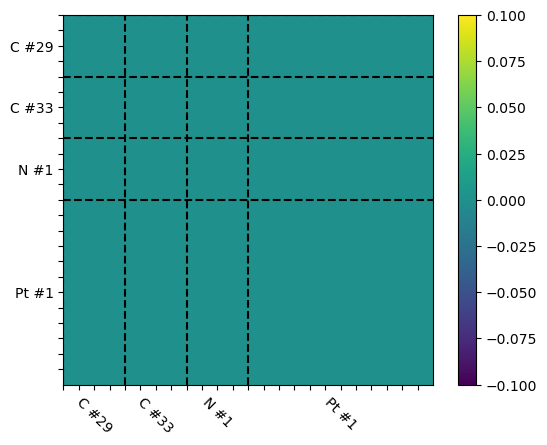

In [14]:
plot_hmat(['C #29', 'C #33', 'N #1', 'Pt #1'], orbs_dict, H_atomic_matrix)

In [ ]:
Emin = np.min(E)
Emax = np.max(E)
dE = 0.0001
Emax = cfunc.adjust_Emax(Emin, Emax, dE)
Egrid = np.arange(Emin, Emax, dE)

In [5]:
COHP_Pt_N1 = pfunc.ez_pCOHP_sum(orbsPt, orbsN1, Egrid, Emin, Emax, dE, pCOHP_uv)
COHP_CbN1_N1 = pfunc.ez_pCOHP_sum(orbsCbN1, orbsN1, Egrid, Emin, Emax, dE, pCOHP_uv)
COHP_Pt_N1_int = pfunc.get_integrated_array(COHP_Pt_N1, dE)
COHP_CbN1_N1_int = pfunc.get_integrated_array(COHP_CbN1_N1, dE)

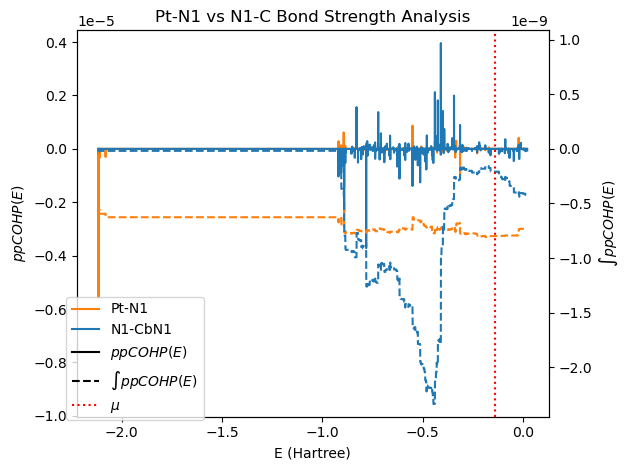

In [6]:
fig, ax = plt.subplots()
ax.plot(Egrid, COHP_Pt_N1, color='C1', label='Pt-N1')
ax.plot(Egrid, COHP_CbN1_N1, color='C0', label='N1-CbN1')
ax.set_xlabel('E (Hartree)')
ax.set_ylabel(r'$ppCOHP(E)$')
axint = ax.twinx()
axint.plot(Egrid, COHP_Pt_N1_int, color='C1', linestyle='--')
axint.plot(Egrid, COHP_CbN1_N1_int, color='C0', linestyle='--')
axint.set_ylabel(r'$\int ppCOHP(E)$')
line1 = ax.plot(0,0,color='black',label=r'$ppCOHP(E)$',linestyle='solid')
line2 = axint.plot(0,0,color='black',label=r'$\int ppCOHP(E)$',linestyle='--')

pfunc.align_yaxis(ax, axint)
plt.axvline(x=mu, color='r', label=r'$\mu$', linestyle='dotted')
plt.title('Pt-N1 vs N1-C Bond Strength Analysis')


fig.legend(loc='lower left', bbox_to_anchor=(0.1, 0.1))
fig.tight_layout()
fig.savefig('integrated_ppCOHP_PtN1_N1CbN1.png')